# Eight Queens Problem

### Section 1: Baseline solution

In [7]:
from utils import Timer
import itertools
import math
import random
import numpy as np
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
class Individual_Basic:
    """This class represents a 8x8 board in the eight queens puzzle"""

    def __init__(self, state=None):
        """
        :param state: pass in a numpy array of integers to set the state, otherwise will be generated randomly
        """
        self.state = state if state is not None else np.random.randint(0, high=8, size=8)
        self.fitness = None

    def cost(self) -> int:
        """Calculates the number of pairs attacking"""
        if self.fitness is None:
            count = 0
            for i in range(len(self.state) - 1):
                # for each queen, look in columns to the right
                # add one to the count if there is another queen in the same row
                count += (self.state[i] == np.array(self.state[i + 1:])).sum()

                # add one to the count for each queen on the upper or lower diagonal
                upper_diagonal = self.state[i] + np.arange(1, 8 - i)
                lower_diagonal = self.state[i] - np.arange(1, 8 - i)
                count += (np.array(self.state[i + 1:]) == upper_diagonal).sum()
                count += (np.array(self.state[i + 1:]) == lower_diagonal).sum()
            self.fitness = count
        return self.fitness

    def is_goal(self) -> bool:
        return self.cost() == 0

    def __str__(self):
        if self.is_goal(): return f"Goal state! {self.state}"
        else: return f"{self.state} cost {self.cost()}"

In [12]:
class Population_Basic:
    """This class represents a population of individual states"""

    def __init__(self, states=None):
        if states is None: self.population = [Individual_Basic() for _ in range(9)]  # initial state
        else: self.population = [Individual_Basic(state=states[s]) for s in range(9)]  # not initial state

    def fitness(self) -> np.ndarray: return np.array([i.cost() for i in self.population])

    def has_the_goal(self) -> bool: return 0 in self.fitness()

    def the_goal(self) -> Individual_Basic:
        for individual in self.population:
            if individual.is_goal(): return individual

    def top_k(self) -> np.ndarray:
        fitness = self.fitness()
        return np.argpartition(fitness, 3)[:3]

In [15]:
class EightQueensRunner_Basic:
    def __init__(self, max_iter=5000, verbose=False):
        self.max_iter = max_iter
        self.verbose = verbose

    @staticmethod
    def product(genes_x: list, genes_y: list) -> np.ndarray:
        return np.array([np.concatenate((X, Y)) for X, Y in itertools.product(genes_x, genes_y)])

    def run(self):
        generation = 1
        next_generation = None
        while generation < self.max_iter:
            # create new generation
            population = Population_Basic(states=next_generation)

            # check for the success
            if population.has_the_goal():
                print(f"Goal state achieved in {generation} iterations. {population.the_goal()}")
                break

            # get best individuals
            top_k = [population.population[i] for i in population.top_k()]
            if self.verbose: print(f"Generation {generation} Top 8:", *(str(top).rjust(30) for top in top_k), sep='\n')

            # select genes
            genes_x = []
            genes_y = []
            for top in top_k:
                genes_x.append(top.state[:3])
                genes_y.append(top.state[3:])
            if self.verbose: print(f"Gene splits:", *(str(gene).rjust(23) for gene in np.concatenate((genes_x, genes_y), 1)), sep='\n')

            # crossover
            next_generation = self.product(genes_x, genes_y)

            # mutate
            for i, individual in enumerate(next_generation):
                for j, gene in enumerate(individual):
                    # 1 in 8 chance that a gene will be mutated
                    if random.uniform(0, 1) >= 1 / 8: continue
                    next_generation[i][j] = random.choice([r for r in range(0, 8) if r != gene])

            if self.verbose: print(f"Next generation:", *(str(gene).rjust(23) for gene in next_generation), sep='\n', end='\n\n')
            generation += 1
        else:
            print('The algorithm failed to reach the goal.')

In [17]:
with Timer(): EightQueensRunner_Basic().run()

Goal state achieved in 318 iterations. Goal state! [2 4 7 3 0 6 1 5]
The query took 283.32520 ms.


### Section 2.1: Extended solution

In [6]:
class Individual:
    """This class represents an individual and contains his genome"""

    def __init__(self, state=None, board_size=8):
        if state is None:
            self.n = board_size
            self.state = np.random.randint(0, high=board_size, size=board_size)
        else:
            if len(state) != board_size:
                raise Exception('Board size and states are not matching.')
            self.n = board_size
            self.state = state
        self.fitness = None

    def cost(self) -> int:
        """Calculates the number of pairs attacking"""
        if self.fitness is None:
            count = 0
            for i in range(len(self.state) - 1):
                # for each queen, look in columns to the right
                # add one to the count if there is another queen in the same row
                count += (self.state[i] == np.array(self.state[i + 1:])).sum()

                # add one to the count for each queen on the upper or lower diagonal
                upper_diagonal = self.state[i] + np.arange(1, self.n - i)
                lower_diagonal = self.state[i] - np.arange(1, self.n - i)
                count += (np.array(self.state[i + 1:]) == upper_diagonal).sum()
                count += (np.array(self.state[i + 1:]) == lower_diagonal).sum()
            self.fitness = count
        return self.fitness

    def is_goal(self) -> bool:
        return self.cost() == 0

    def __str__(self):
        if self.is_goal(): return f"Goal state! {self.state}"
        else: return f"{self.state} cost {self.cost()}"

In [7]:
class Population:
    """This class represents a population of individual states"""

    def __init__(self, top_individuals: int, board_size: int, crossover: staticmethod, states=None):
        self.k = top_individuals
        self.n = board_size
        self.cf = crossover
        self.population_size = crossover(top_individuals)

        if states is None: self.population = [Individual(board_size=board_size) for _ in range(self.population_size)]  # initial state
        else: self.population = [Individual(state=states[s], board_size=board_size) for s in range(self.population_size)]  # not initial state

    def fitness(self) -> np.ndarray: return np.array([i.cost() for i in self.population])

    def has_the_goal(self) -> bool: return 0 in self.fitness()

    def the_goal(self) -> Individual:
        for individual in self.population:
            if individual.is_goal(): return individual

    def top_k(self) -> np.ndarray:
        fitness = self.fitness()
        return np.argpartition(fitness, self.k)[:self.k]

In [8]:
class EightQueensRunner:
    """This is a controller class for the eight queens problem"""

    def __init__(self, top_individuals: int, crossover: str, mutation_rate: float, board_size: int, max_iter=5000, verbose=0):
        """
        :param top_individuals: the amount of top individuals
        :param crossover: the way in which genes from the best individual crossover
        :param mutation_rate: rate at which the genes mutate
        :param board_size: determines the size of board
        :param max_iter: upper limit for the number of iterations
        :param verbose: verbosity level
        """
        self.k = top_individuals
        self.c = crossover
        self.m = mutation_rate
        self.n = board_size
        self.max_iter = max_iter
        self.verbose = verbose

        if board_size < 4: raise Exception('No solution for board size smaller than 4.')
        if crossover == 'permutations' and top_individuals < 3: raise Exception("Permutations crossover require top_individuals > 2.")
        self.selection_split = math.ceil(self.n / 2 - 1)
        self.cf = {
                'permutations': lambda k: math.factorial(k) // math.factorial(k - 2),
                'product': lambda k: k ** 2,
                'combinations_with_rep': lambda k: math.factorial(k + 1) // (2 * math.factorial(k - 1))
        }[crossover]

    @staticmethod
    def permutations(genes_x: list, genes_y: list) -> np.ndarray:
        """ab, ac, ba, bc, ca, cb"""
        shuffled = []
        for xi, X in enumerate(genes_x):
            for yi, Y in enumerate(genes_y):
                if xi == yi: continue
                shuffled.append(np.concatenate((X, Y)))
        return shuffled

    @staticmethod
    def product(genes_x: list, genes_y: list) -> np.ndarray:
        """aa, ab, ac, ba, bb, bc, ca, cb, cc"""
        return np.array([np.concatenate((X, Y)) for X, Y in itertools.product(genes_x, genes_y)])

    @staticmethod
    def combinations_with_rep(genes_x: list, genes_y: list) -> np.ndarray:
        """aa, ab, ac, bb, bc, cc"""
        shuffled = []
        combinations = set()
        for xi, X in enumerate(genes_x):
            for yi, Y in enumerate(genes_y):
                if f"{xi}{yi}" in combinations: continue
                combinations.update([f"{xi}{yi}", f"{yi}{xi}"])
                shuffled.append(np.concatenate((X, Y)))
        return shuffled

    def run(self):
        generation = 1
        next_generation = None
        while generation < self.max_iter:
            # create new generation
            population = Population(top_individuals=self.k, board_size=self.n, crossover=self.cf, states=next_generation)

            # check for the success
            if population.has_the_goal():
                if self.verbose >= 1: print(f"Goal state achieved in {generation} iterations. {population.the_goal()}")
                break

            # get best individuals
            top_k = [population.population[i] for i in population.top_k()]
            if self.verbose == 2: print(f"Generation {generation} Top {self.k}:", *(str(top).rjust(30) for top in top_k), sep='\n')

            # select genes
            genes_x = []
            genes_y = []
            for top in top_k:
                genes_x.append(top.state[:self.selection_split])
                genes_y.append(top.state[self.selection_split:])
            if self.verbose == 2: print(f"Gene splits:", *(str(gene).rjust(23) for gene in np.concatenate((genes_x, genes_y), 1)), sep='\n')

            # crossover
            next_generation = getattr(self, self.c)(genes_x, genes_y)

            # mutate
            for i, individual in enumerate(next_generation):
                for j, gene in enumerate(individual):
                    # m chance that a gene will be mutated
                    if random.uniform(0, 1) >= self.m: continue
                    next_generation[i][j] = random.choice([r for r in range(0, self.n) if r != gene])

            if self.verbose == 2: print(f"Next generation:", *(str(gene).rjust(23) for gene in next_generation), sep='\n', end='\n\n')
            generation += 1
        else:
            if self.verbose >= 1: print('The algorithm failed to reach the goal.')

In [9]:
with Timer() as t:
    EightQueensRunner(top_individuals=5,
                      crossover='permutations',
                      mutation_rate=1 / 8,
                      board_size=8,
                      verbose=1).run()

Goal state achieved in 9 iterations. Goal state! [2 0 6 4 7 1 3 5]
The query took 21.00539 ms.


### Section 2.2: Hyperparameter search

#### Grid Search script

<pre><code>
cf = {
    'permutations': lambda k: math.factorial(k) // math.factorial(k - 2),
    'product': lambda k: k ** 2,
    'combinations_with_rep': lambda k: math.factorial(k + 1) // (2 * math.factorial(k - 1))
}


def process(params: tuple) -> dict:
    N, K, M, C = params
    size = cf[C](K) * N  # crossover(top_individuals) * board_size
    times = []
    for _ in range(100):
        with Timer(verbose=False) as t:
            EightQueensRunner(top_individuals=K,
                              crossover=C,
                              mutation_rate=M,
                              board_size=N,
                              max_iter=2500).run()
        times.append(t.getAbsoluteInterval())
    avg_time = sum(times) / len(times)
    return {'size': size,
            'time': avg_time,
            'top_individuals': K,
            'crossover': C,
            'mutation_rate': M,
            'board_size': N}

n_range = range(4, 13)
k_range = range(3, 7)
m_range = np.linspace(0.05, 0.25, 26)
c_range = ['product', 'permutations', 'combinations_with_rep']
data = []

with Pool(8) as pool:
    for result in pool.imap_unordered(process, itertools.product(n_range, k_range, m_range, c_range), chunksize=3):
        print(result)
        data.append(result)

data = pd.DataFrame(data)
data.to_csv('gs_FullSearch.csv', index=False)</code></pre>

#### Data analysis

In [10]:
data = pd.read_csv('gs_FullSearch.csv')
sns.set_theme()

##### Best scores for each n

In [11]:
for n in range(4, 13):
    n_data = data.loc[data.board_size == n].sort_values('time')
    top1prc = n_data.time.iloc[0] * 1.01 + n_data.time.iloc[-1] * 0.01
    print(f"\nfor {n=} top 1% of times were achieved by:\n{n_data.loc[n_data.time <= top1prc].drop('board_size', axis=1)}")


for n=4 top 1% of times were achieved by:
     size      time  top_individuals     crossover  mutation_rate
8      36  0.005157                3       product           0.21
2      36  0.005157                3       product           0.19
135    80  0.005241                5  permutations           0.21
131   100  0.005397                5       product           0.20

for n=5 top 1% of times were achieved by:
     size      time  top_individuals              crossover  mutation_rate
554    75  0.010001                5  combinations_with_rep           0.21
559   100  0.010313                5           permutations           0.23
556   100  0.010313                5           permutations           0.22
550   100  0.010313                5           permutations           0.20
469    60  0.010325                4           permutations           0.14
423    45  0.010398                3                product           0.20
421    30  0.010414                3           permutations

In [12]:
average_parameters = []
for n in range(4, 13):
    parameters = {}
    best50 = data.loc[data.board_size == n].sort_values('time')[:50]
    parameters['n'] = n
    parameters['k'] = round(best50.top_individuals.mean(), 4)
    parameters['m'] = round(best50.mutation_rate.mean(), 4)
    parameters['cf'] = {
        'prod': best50.loc[best50.crossover == 'product'].crossover.size,
        'perm': best50.loc[best50.crossover == 'permutations'].crossover.size,
        'comb': best50.loc[best50.crossover == 'combinations_with_rep'].crossover.size
    }
    average_parameters.append(parameters)
print(*(n for n in average_parameters), sep='\n')

{'n': 4, 'k': 4.68, 'm': 0.2058, 'cf': {'prod': 23, 'perm': 24, 'comb': 3}}
{'n': 5, 'k': 4.4, 'm': 0.192, 'cf': {'prod': 20, 'perm': 19, 'comb': 11}}
{'n': 6, 'k': 4.2, 'm': 0.201, 'cf': {'prod': 13, 'perm': 16, 'comb': 21}}
{'n': 7, 'k': 4.34, 'm': 0.1718, 'cf': {'prod': 18, 'perm': 21, 'comb': 11}}
{'n': 8, 'k': 4.9, 'm': 0.1712, 'cf': {'prod': 23, 'perm': 20, 'comb': 7}}
{'n': 9, 'k': 4.22, 'm': 0.1252, 'cf': {'prod': 23, 'perm': 24, 'comb': 3}}
{'n': 10, 'k': 4.02, 'm': 0.1074, 'cf': {'prod': 24, 'perm': 26, 'comb': 0}}
{'n': 11, 'k': 4.86, 'm': 0.11, 'cf': {'prod': 21, 'perm': 19, 'comb': 10}}
{'n': 12, 'k': 4.66, 'm': 0.0954, 'cf': {'prod': 16, 'perm': 23, 'comb': 11}}


##### Size vs time

In [13]:
time_rolling_avg = data.sort_values('size')['time'].rolling(window=400, 
                                                            min_periods=0,
                                                            center=True).mean()
size_time_average = pd.concat([data['size'], time_rolling_avg], axis=1).sort_values('size')

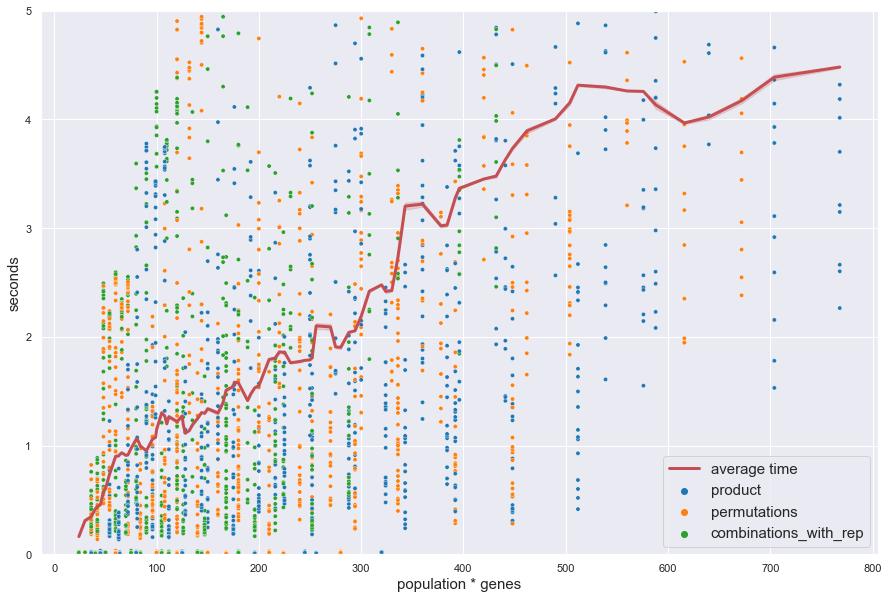

In [14]:
plt.figure(figsize=(15, 10))
plt.ylim(0, 5)
plt.xlabel('population * genes', fontsize=15)
plt.ylabel('seconds', fontsize=15)
a = sns.scatterplot(x='size', y='time', data=data, hue='crossover', 
                    hue_order=['product', 'permutations', 'combinations_with_rep'], 
                    size=2.3, palette='tab10')
b = sns.lineplot(x='size', y='time', data=size_time_average, 
                 linewidth=3, color='r', label='average time')
h,l = a.get_legend_handles_labels()
plt.legend(h[0:4],l[0:4], loc=4, fontsize=15)
plt.show(a, b)

##### Mutation rate vs time

In [15]:
n_all = data.sort_values('time')
x = data.groupby(['board_size', 'mutation_rate'])['time'].mean().to_frame()
x['mutation_rate'] = x.index.to_frame()['mutation_rate']
x['board_size'] = x.index.to_frame()['board_size']
x.reset_index(drop=True, inplace=True)
n_all = pd.merge(n_all, x, how='inner', on=['mutation_rate', 'board_size'])

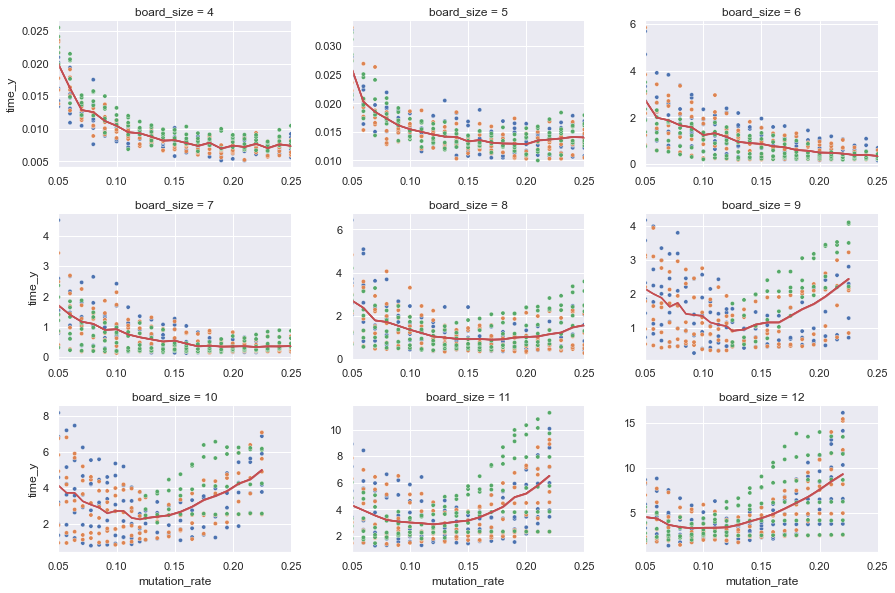

In [16]:
g = sns.FacetGrid(n_all, col='board_size', hue='crossover', col_wrap=3, 
                  sharey=False, sharex=False, margin_titles=True, 
                  legend_out=True, xlim=(0.05, 0.25), height=2.8, aspect=1.5)
g.map(sns.scatterplot, 'mutation_rate', 'time_x', size=1.2)
g.map(sns.lineplot, 'mutation_rate', 'time_y', linewidth=1.5, color='r')
plt.show()

##### Crossover function vs time

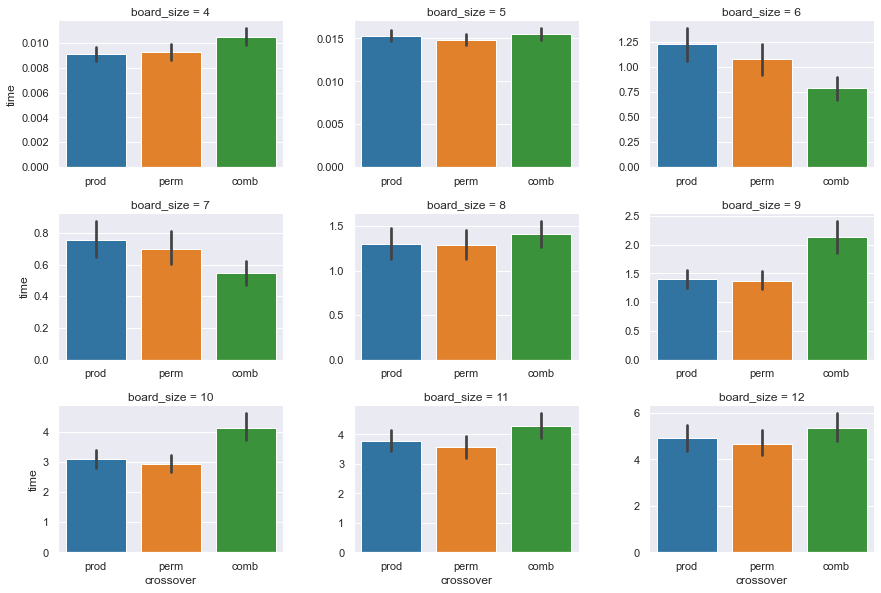

In [17]:
g = sns.FacetGrid(data.sort_values('time'), col='board_size', col_wrap=3, 
                  sharey=False, sharex=False, margin_titles=True, 
                  legend_out=False, height=2.8, aspect=1.5)
g.map(sns.barplot, 'crossover', 'time', 
      order=['product', 'permutations', 'combinations_with_rep'],
      palette='tab10')
g.set(xticklabels=['prod', 'perm', 'comb'])
plt.show()

##### Top k individuals vs time

In [18]:
n_all = data.sort_values('time')
y = data.groupby(['board_size', 'top_individuals'])['time'].mean().to_frame()
y['top_individuals'] = y.index.to_frame()['top_individuals']
y['board_size'] = y.index.to_frame()['board_size']
y.reset_index(drop=True, inplace=True)
n_all = pd.merge(n_all, y, how='inner', on=['top_individuals', 'board_size'])

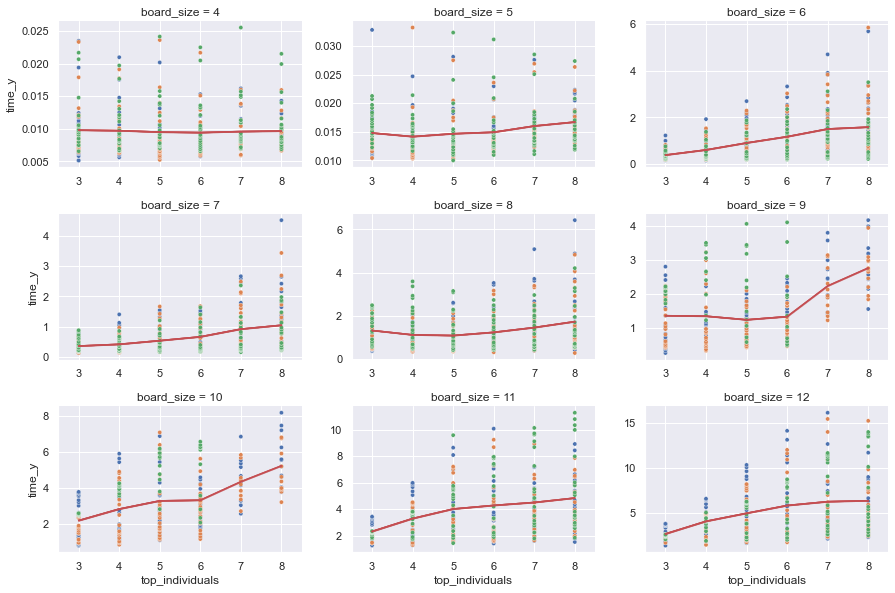

In [19]:
g = sns.FacetGrid(n_all, col='board_size', hue='crossover', col_wrap=3, 
                  sharey=False, sharex=False, margin_titles=True, 
                  legend_out=True, xlim=(2.5, 8.5), height=2.8, aspect=1.5)
g.map(sns.scatterplot, 'top_individuals', 'time_x', size=1.2)
g.map(sns.lineplot, 'top_individuals', 'time_y', linewidth=1.5, color='r')
plt.show()